In [3]:
import pickle
import argparse
import itertools

import os

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy

import sys
sys.path.append('../scripts/observation')

import dolmino_sampling_sweep as dm

In [86]:
def z_to_logp(z_score,eps=1e-6):
    return np.log10(scipy.stats.norm.sf(z_score)+eps)

def get_base_args(save_dir):
    parser = argparse.ArgumentParser()
    
    parser.add_argument("--save_dir", type=str, required=True)
    parser.add_argument("--model_size", type=str, default="1B")
    parser.add_argument("--sampling_model_id", type=int, default=0)
    parser.add_argument("--max_tokens", type=int, default=32)
    parser.add_argument("--prompt", type=str, default=None)

    base_args = parser.parse_args(["--save_dir", save_dir])

    base_args.model_name = dm.MODEL_NAME_DICT[base_args.model_size]
    base_args.revision_template = dm.REVISION_TEMPLATE_DICT[base_args.model_size]

    return base_args

def fix_args(args):
    args.model_name = dm.MODEL_NAME_DICT[args.model_size]
    args.revision_template = dm.REVISION_TEMPLATE_DICT[args.model_size]

    return args

def fix_arg_order(args):
    ordered_args = argparse.Namespace()

    ordered_args.save_dir = args.save_dir
    ordered_args.model_size = args.model_size
    ordered_args.sampling_model_id = args.sampling_model_id
    ordered_args.max_tokens = args.max_tokens
    ordered_args.prompt = args.prompt

    ordered_args.model_name = args.model_name
    ordered_args.revision_template = args.revision_template
    
    ordered_args.n_sample = args.n_sample
    ordered_args.sampling_seed = args.sampling_seed
    ordered_args.temperature = args.temperature

    return ordered_args


def get_experiment(experiment_config, new_root='../dolmino-stuff', old_root='./dolmino-stuff'):
    base_args = get_base_args(save_dir=old_root)
    args = dm.build_args(base_args,experiment_config)
    args = fix_args(args)
    args = fix_arg_order(args)

    old_path = dm.get_experiment_log_path(args)
    relative_path = os.path.relpath(old_path, old_root)
    new_path = os.path.join(new_root, relative_path)

    experiment_result = pickle.load(open(new_path,'rb'))
    
    return experiment_result
    

def get_experiment_sweep(
    base_config, 
    sweep_param, 
    sweep_values, 
    transform=None, 
    seed_configs=None, 
    new_root='../dolmino-stuff', 
    old_root='./dolmino-stuff'
):
    if seed_configs is None:
        seed_configs = {"sampling_seed": list(range(10)),"sampling_model_id": list(range(3))}
    
    sweep_results = {
        "mean": dict(),
        "std": dict()
    }

    seed_names = list(seed_configs.keys())
    seed_values = [seed_configs[name] for name in seed_names]
    seed_combinations = list(itertools.product(*seed_values))
    
    for sweep_value in sweep_values:
        results = []
        for seeds in seed_combinations:
            seed_config = dict(zip(seed_names, seeds))
            
            experiment_config = {k : v for k,v in base_config.items()}
            experiment_config.update(seed_config)
            
            experiment_config[sweep_param] = sweep_value

            experiment_result = get_experiment(experiment_config, new_root, old_root)
            results.append(experiment_result["z_score"])

        if transform is not None:
            results = [transform(x) for x in results]
        
        sweep_results["mean"][sweep_value] = np.mean(results)
        sweep_results["std"][sweep_value] = np.std(results)

    return sweep_results

def get_plot(
    plot_configs, 
    plot_names, 
    sweep_param, 
    sweep_values,
    xlabel=None,
    ylabel="p-value (log-10)",
    styles=None,
    colors=None,
    in_legend=True,
    x_transform=None,
    y_transform=z_to_logp,
    seed_configs=None, 
    new_root='../dolmino-stuff', 
    old_root='./dolmino-stuff',
):
    if xlabel is None:
        xlabel = sweep_param
    if in_legend is True:
        in_legend = [True] * len(plot_configs)
    sns.set_theme()
    plt.figure() 
    for i,(base_config,legend_tag) in enumerate(zip(plot_configs,plot_names)):
        sweep_results = get_experiment_sweep(
            base_config=base_config, 
            sweep_param=sweep_param, 
            sweep_values=sweep_values, 
            seed_configs=seed_configs,
            transform=y_transform,
            new_root=new_root,
            old_root=old_root,
        )
    
        xs = list(sweep_results['mean'].keys())
        
        m  = np.array([sweep_results['mean'][x] for x in xs], float)
        s  = np.array([sweep_results['std'][x]  for x in xs],  float)

        style = styles[i] if styles else '-'
        color = colors[i] if colors else None
        include = in_legend[i]

        if x_transform is not None:
            xs = [x_transform(x) for x in xs]

        print(legend_tag)
        print(xs)
        print(m)
        
        plt.plot(xs, m, label=legend_tag if include else None, linestyle=style, color=color)
        plt.fill_between(xs, m - s, m + s, alpha=0.2, color=color)
        
    plt.xlabel(xlabel); plt.ylabel(ylabel); plt.legend(); plt.tight_layout(); plt.show()

def get_colors(k):
    return plt.rcParams['axes.prop_cycle'].by_key()['color'][:k]

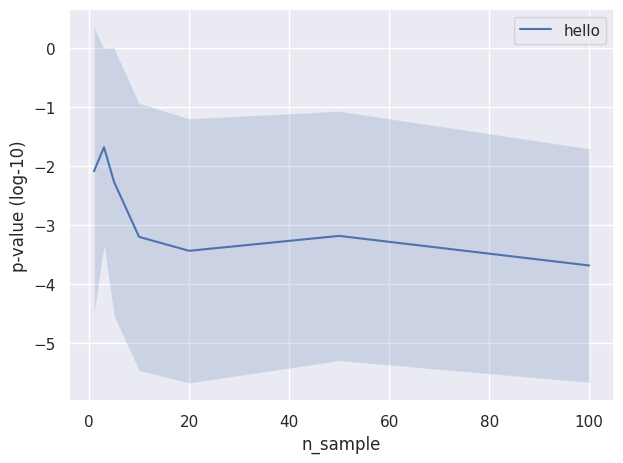

In [77]:
base_config = {
        "save_dir": './dolmino-stuff',
        "temperature": 1.0,
        "model_size": "7B"
    }
sweep_param = "n_sample"
sweep_values = [1, 3, 5, 10, 20, 50, 100]

get_plot([base_config], ["hello"], sweep_param, sweep_values, y_transform=z_to_logp)

In [65]:
get_experiment({"model_size":"7B","sampling_model_id":2,"n_sample":10,"temperature":1.0, "sampling_seed":9})

{'z_score': 4.565569217538209,
 'args': Namespace(save_dir='./dolmino-stuff', model_size='7B', sampling_model_id=2, max_tokens=32, prompt=None, model_name='allenai/OLMo-2-1124-7B', revision_template='stage2-ingredient{revision_id}-step11931-tokens50B', n_sample=10, sampling_seed=9, temperature=1.0)}

In [21]:
experiment_result = pickle.load(open("../dolmino-stuff/experiment_logs/ffc15cf497bdcb9e/log.pkl","rb"))

In [22]:
experiment_result

{'z_score': 0.6507949447297501,
 'args': Namespace(save_dir='./dolmino-stuff', model_size='7B', sampling_model_id=2, max_tokens=32, prompt=None, model_name='allenai/OLMo-2-1124-7B', revision_template='stage2-ingredient{revision_id}-step11931-tokens50B', n_sample=3, sampling_seed=9, temperature=1.0)}

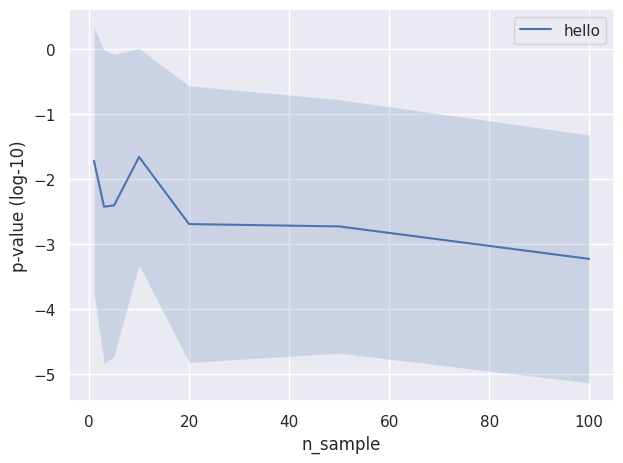

In [78]:
base_config = {
        "save_dir": './dolmino-stuff',
        "temperature": 1.0,
        "model_size": "1B"
    }
sweep_param = "n_sample"
sweep_values = [1, 3, 5, 10, 20, 50, 100]

get_plot([base_config], ["hello"], sweep_param, sweep_values, y_transform=z_to_logp)

1B
[32, 96, 160, 320, 640, 1600, 3200]
[-1.72189245 -2.42568758 -2.40721609 -1.66111154 -2.69369797 -2.72978306
 -3.22925899]
7B
[32, 96, 160, 320, 640, 1600, 3200]
[-2.09118594 -1.68444504 -2.27143388 -3.20218287 -3.43875945 -3.18633027
 -3.68719332]


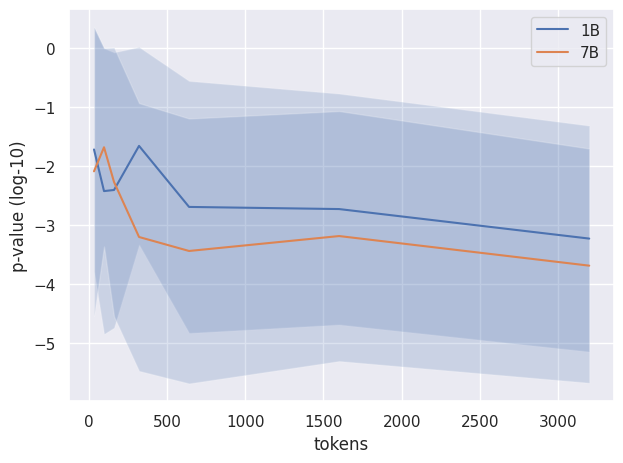

In [88]:
base_configs = [
    {
        "save_dir": './dolmino-stuff',
        "temperature": 1.0,
        "model_size": "1B"
    },
    {
        "save_dir": './dolmino-stuff',
        "temperature": 1.0,
        "model_size": "7B"
    },
]
sweep_param = "n_sample"
sweep_values = [1, 3, 5, 10, 20, 50, 100]

get_plot(
    plot_configs=base_configs, 
    plot_names=["1B","7B"], 
    sweep_param=sweep_param, 
    sweep_values=sweep_values, 
    y_transform=z_to_logp, 
    x_transform=lambda x : 32*x,
    xlabel="tokens"
)